 **Проект 4. Компьютер говорит нет!**
 
Цель проекта:
Построение модели, предсказывающей вероятность дефолта по кредиту на основе данных по клиенту

1. Загружаем библиотеки

In [116]:
import pandas as pd
import numpy as np
from pandas import Series

import pandas_profiling
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures

import imblearn
from imblearn.over_sampling import SMOTE

2. Загружаем датасет, смотрим свойства

In [78]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [79]:
path = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(path +'/train.csv')
test = pd.read_csv(path +'test.csv')
sample = pd.read_csv(path +'/sample_submission.csv')

In [80]:
train.info

<bound method DataFrame.info of        client_id   app_date education sex  age car car_type  decline_app_cnt  \
0          25905  01FEB2014       SCH   M   62   Y        Y                0   
1          63161  12MAR2014       SCH   F   59   N        N                0   
2          25887  01FEB2014       SCH   M   25   Y        N                2   
3          16222  23JAN2014       SCH   F   53   N        N                0   
4         101655  18APR2014       GRD   M   48   N        N                0   
...          ...        ...       ...  ..  ...  ..      ...              ...   
73794      54887  04MAR2014       GRD   F   45   N        N                0   
73795      76821  24MAR2014       SCH   M   41   Y        Y                0   
73796     103695  22APR2014       SCH   M   31   N        N                0   
73797        861  04JAN2014       SCH   F   29   N        N                0   
73798      15796  23JAN2014       GRD   M   34   N        N                0   

       

* Описания полей¶
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов клиента в БКИ о своей кредитной истории
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредит

In [81]:
print(train.info())
print('Train size: ', train.shape)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0  
1             3   19000    4           1                N        0  
2             2   30000    1           4                Y        0  
3             3   10000    1           3                N        0  
4             3   30000    1           4                Y        0

In [82]:
print(test.info())
print('Test size: ', train.shape)
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      74835  22MAR2014       GRD   M   29   Y        Y                0   
1      17527  24JAN2014       SCH   F   39   N        N                5   
2      75683  23MAR2014       UGR   M   50   Y        Y                0   
3      26883  03FEB2014       SCH   M   56   N        N                0   
4      28862  04FEB2014       GRD   F   38   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.271884                3             50             1   
1          0  -1.504999                2             50             1   
2          0  -1.691339                1             50             1   
3          0  -2.374182                1             40             1   
4          0  -2.487502                0             80             2   

   work_address  income  sna  first_time foreign_passport  
0             2   50000    1           4                N  
1             2    5000    4           3                N  
2             2   30000    1           3                Y  
3             2   17000    1           3                N  
4             3  120000    1           3                N

In [83]:
profile = ProfileReport(train)
profile

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

ProfileReport показал, что пропуски (307) есть только в признаке образования. 

3. Создадим функции

In [84]:
# Функция, присвающая выбросам значения в межквартильном пределе  
def cut_IQR(column, data):
    Q25 = train[column].quantile(0.25)
    Q75 = train[column].quantile(0.75)
    IQR = Q75 - Q25
    l_bound = Q25 - 1.5*IQR
    r_bound = Q75 + 1.5*IQR

    data[column] = data[column].apply(lambda x: r_bound if x  >=  r_bound else x)
    data[column] = data[column].apply(lambda x: l_bound if x  <=  l_bound else x)

In [85]:
# Функция расчета точности, а также составляющих матрицы ошибок
def calc_accuracy(y_true, y_pred):
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    acc = (TP + TN) / (P + N)
    return acc, TP, TN, P, N

In [86]:
# Метрики модели
def metrics(y_test, probs, y_pred_test):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

    f1_test_n = f1_score(y_test, y_pred_test)
    print('f1 score:=',round(f1_test_n,4))

    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    print('precision: {:.4f}\nrecall: {:.4f}'.format(precision, recall))

    calc_accuracy(y_test, y_pred_test)
    acc, TP, TN, P, N = calc_accuracy(y_test, y_pred_test)
    print('TP = {}\nTN = {}\nP = {}\nN = {}\nacc = {:.4f}'.format(TP, TN, P, N, acc))

    conf_mat = confusion_matrix(y_test, y_pred_test)
    print('Confusion matrix:\n{}'.format(conf_mat))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=model.classes_)
    disp.plot()

4. Предварительное разделение признаков

In [87]:
# пребразуем значения признака в формат datetime
train.app_date = pd.to_datetime(train.app_date)
print('First app:',train.app_date.min())
print('Last app:', train.app_date.max())

First app: 2014-01-01 00:00:00
Last app: 2014-04-30 00:00:00


Видимо, данные заявок на кредит, которые были собраны в срок с 1 января до 30 апреля 2014 г.
Создадим несколько категориальных и бинарных признаков из app_date:

In [88]:
# бинарный для заявок в выходные
train['is_weekend'] = train.app_date.dt.weekday > 4
# категориальный для месяцев заявок
train['month'] = train.app_date.dt.month
# категориальный для дней
train['day'] = train.app_date.dt.weekday
# бинарный для конца месяца
train['start_month'] = train.app_date.dt.day < 7

In [89]:
# Остальные признаки
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work','is_weekend','start_month']
cat_cols = ['education', 'home_address', 'work_address','sna','first_time','month','day']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki','region_rating']

5. Смотрим числовые признаки

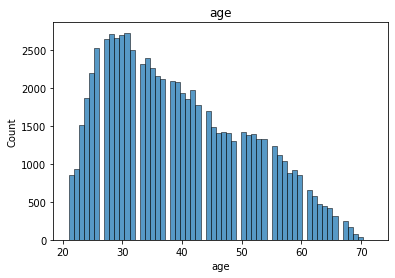

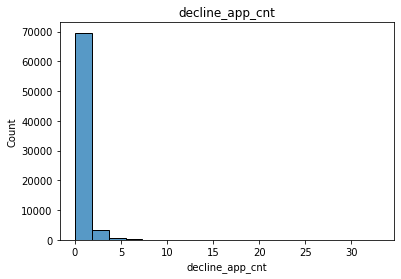

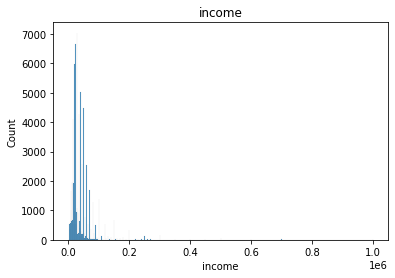

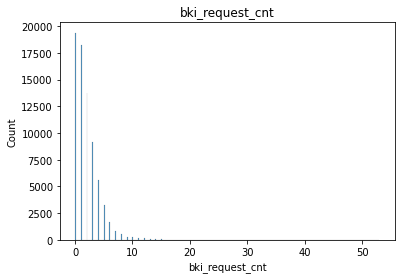

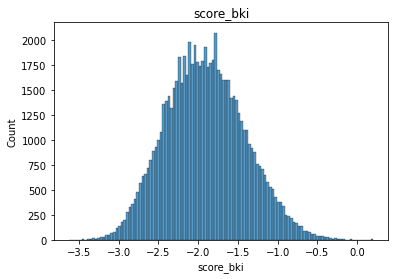

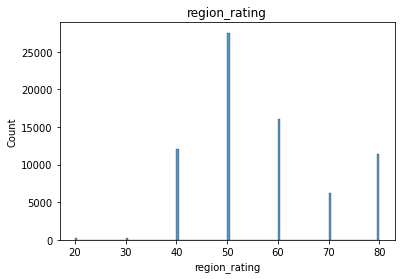

In [90]:
for i in num_cols:
    plt.figure()
    sns.histplot(train[i], kde = False,)
    plt.title(i)
    plt.show()

Нормально распределён только признак score_bki. Остальные требуют преобразования.

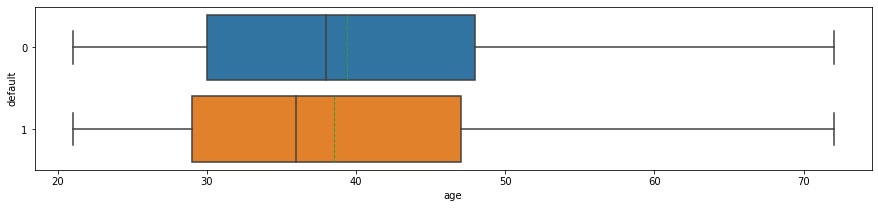

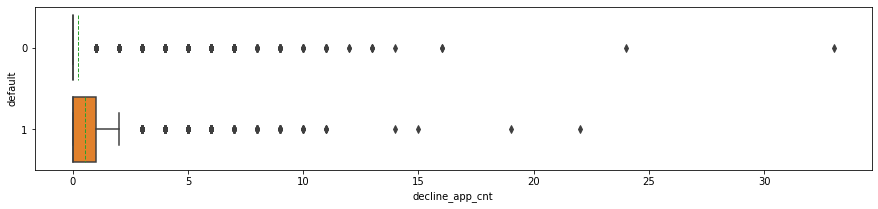

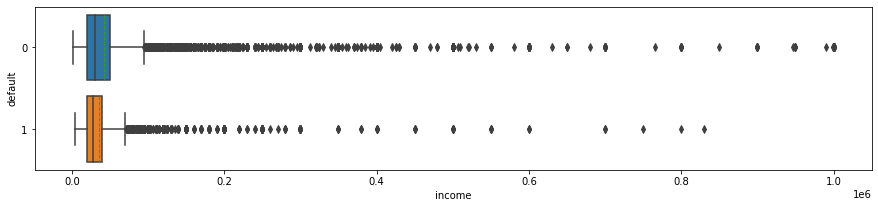

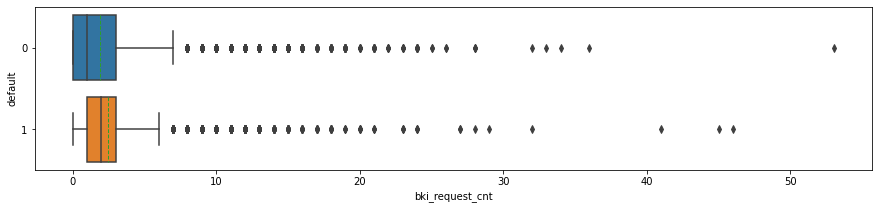

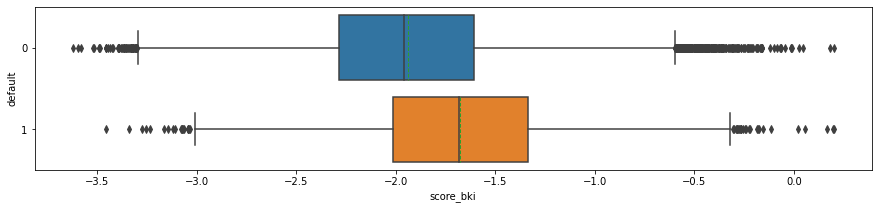

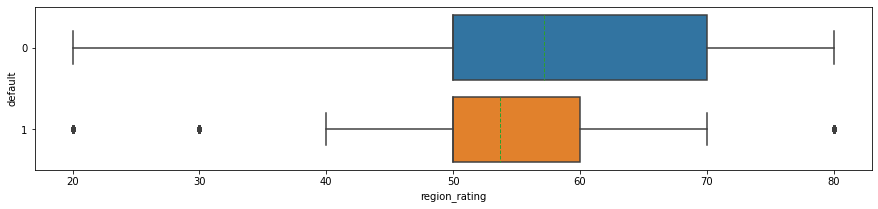

In [91]:
#Построим графики
for col in num_cols:
    plt.figure(figsize=(15,3))
    sns.boxplot(y = train['default'], x = train[col],showmeans=True, meanline=True, orient='h')

Выводы:

* Средний возраст клиентов, у которых был дефолт, ниже.
* Клиенты, у которых не было дефолтов, в среднем почти не получали отказов в кредите, но есть исключения.
* Клиенты с дефолтами в среднем имеют более высокий показатель отказов.
* Средний доход клиентов без дефолтов выше.
* Средняя рейтинга регионов клиентов без дефолта выше, но межквартильное расстояние больше.
* Выбросы есть у признаков:
score_bki
bki_request_cnt
income
decline_app_cnt

Корреляция числовых признаков:

<AxesSubplot:>

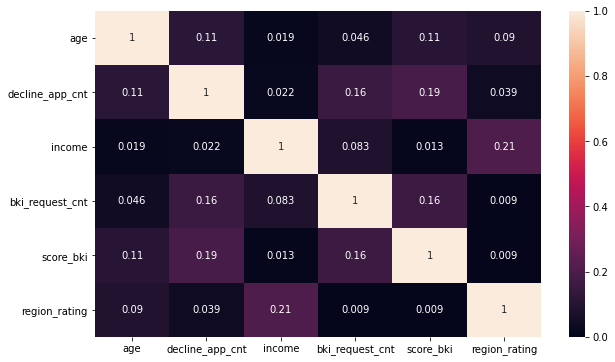

In [92]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Сильные корреляции между числовыми переменными отсутствуют. Самая большая связь наблюдается между доходом и рейтингом регионов, а также между скорингом банка и отказом в кредите.

In [93]:
# Ограничим выбросы в отказах до 8
train['decline_app_cnt'] = train['decline_app_cnt'].apply(lambda x: 8 if x  >=  8 else x)
# Создадим бинарную переменную, учитывая, что большое количество клиентов вообще не имеет отказов
train['decline_app_bin'] = train['decline_app_cnt'].apply(lambda x: 1 if x  >=  1 else 0)

In [94]:
# Создадим бинарный признак для доходов 
train['income_bin'] = train['income'].apply(lambda x: 1 if x  < 25000  else 0)

In [95]:
# В признаках количества заявок на кредит и доходе ограничим значения до IQR
for col in ['bki_request_cnt','income',]:
    cut_IQR(col, train)

In [96]:
#обновим список переменных
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work','is_weekend',
            'start_month','decline_app_bin','income_bin']
cat_cols = ['education', 'home_address', 'work_address','sna','first_time','month','day']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki','region_rating']

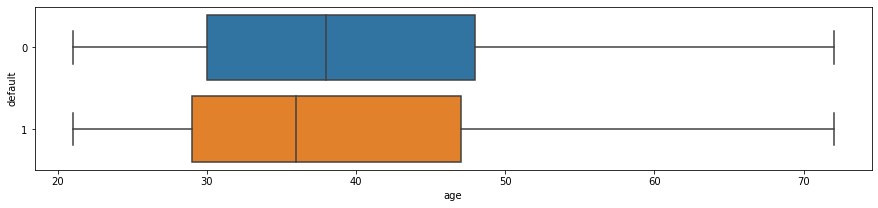

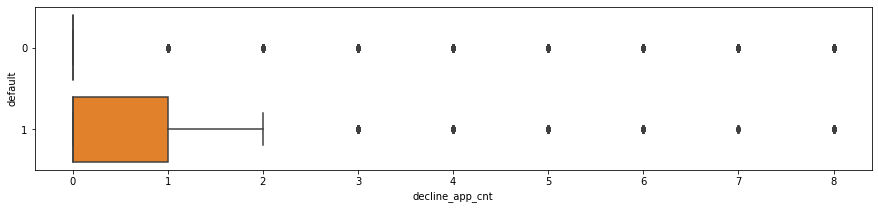

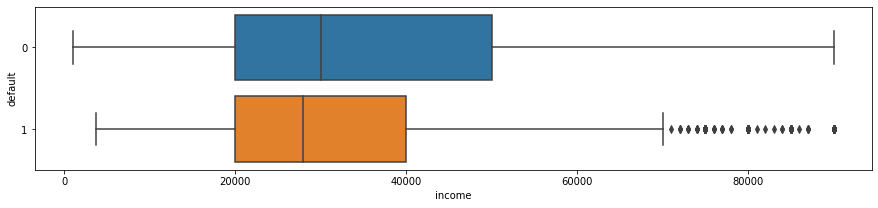

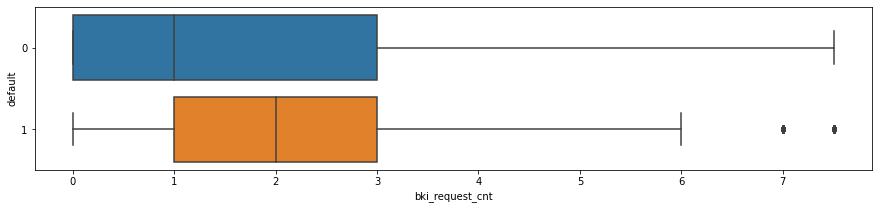

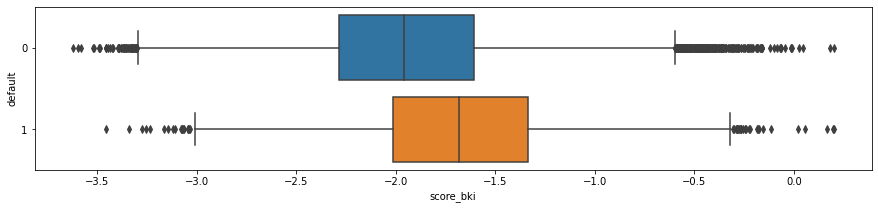

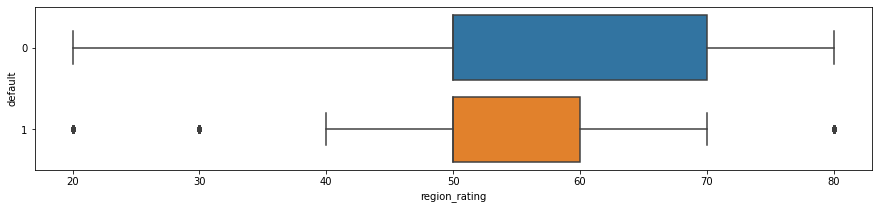

In [97]:
#посмотрим, как изменились графики
for col in num_cols:
    plt.figure(figsize=(15,3))
    sns.boxplot(y = train['default'], x = train[col], orient='h')

<AxesSubplot:>

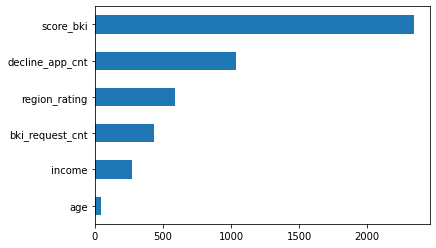

In [98]:
# Посмотрим на значимость влияния числовых факторов на целевую переменную в обучаемой выборке
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Наибольшее влияние оказывают скоринг банка и количество отказов.

6. Смотрим бинарные признаки

In [99]:
label_encoder = LabelEncoder()
for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])

<AxesSubplot:>

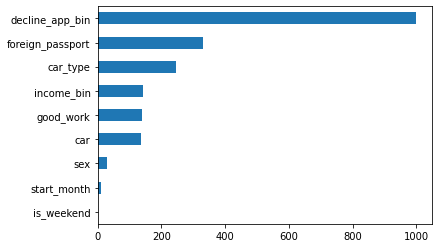

In [100]:
# Посмотрим на значимость бинарных переменных в обучаемой выборке
imp_num = pd.Series(f_classif(train[bin_cols], train['default'])[0], index = bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Сильнее всего влияет отсутствие или наличие отказа в кредите. Довольно сильно влияет наличие загранпаспорта и тип машины.

7. Категориальные признаки.

Как мы помним, в графе Образование были пропуски.

In [101]:
# Посчитаем моду и заменим пропуски на моду
mode_education  = train['education'].mode()[0]
train['education'] = train['education'].apply(lambda x: mode_education if str(x) == 'nan' else x)


<AxesSubplot:>

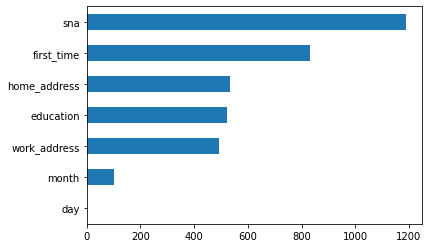

In [102]:
# Закодируем образование согласно степени образования
education_dict = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 4, 'ACD': 5}
train.education = train.education.replace(education_dict)    
# Посмотрим на значимость категориальных переменных
imp_num = pd.Series(f_classif(train[cat_cols], train['default'])[0], index = cat_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

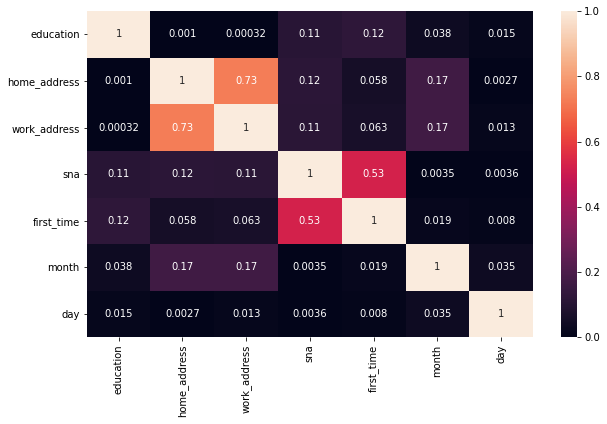

In [103]:
# Посмотрим корреляцию
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(train[cat_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Самая сильная корреляция наблюдается между рабочим и домашним адресами. Также есть связь между связью заемщика и первой записью о заемщике в банке.

<AxesSubplot:>

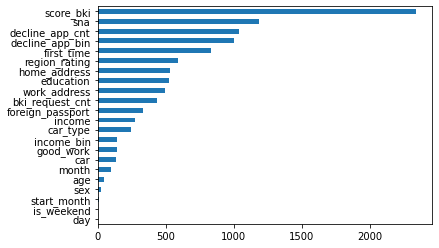

In [104]:
# Рассмотрим значимость всех переменных
imp_num = pd.Series(f_classif(train[cat_cols + num_cols + bin_cols], 
                              train['default'])[0], index = cat_cols + num_cols + bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [105]:
# окончательный список признаков
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work','start_month',
            'decline_app_bin','income_bin']
cat_cols = ['education', 'home_address','sna','work_address','first_time','month',]
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki','region_rating']

8. Тестируем модель

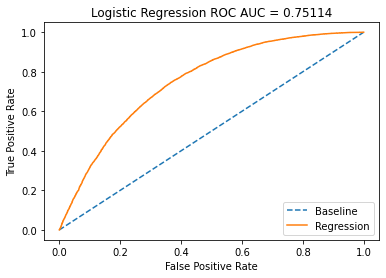

f1 score:= 0.6898
precision: 0.6818
recall: 0.6979
TP = 8999
TN = 8678
P = 12894
N = 12877
acc = 0.6859
Confusion matrix:
[[8678 4199]
 [3895 8999]]


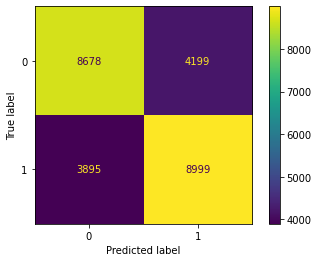

In [106]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
X_num = train[num_cols].values
X_bin = train[bin_cols].values

# Объединяем три типа данных в одну матрицу значений Х
X = np.hstack([X_num, X_bin, X_cat])
y = train['default'].values

X_resampled, y_resampled = SMOTE().fit_resample(X, y)

# Делим данные
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.20,  random_state=42)
# Стандартизируем числовые переменные
scaler = StandardScaler()

X_train[:,:len(num_cols)] = scaler.fit_transform(X_train[:,:len(num_cols)]) 
X_val[:,:len(num_cols)] = scaler.transform(X_val[:,:len(num_cols)])

# Обучаем модель только с указанием максимального значения итерации
model = LogisticRegression(max_iter=190)
model.fit(X_train, y_train)

# Предсказываем на разделенной выборке из train
y_pred_val = model.predict(X_val)
probs = model.predict_proba(X_val)
probs = probs[:,1]

# Выводим показатели метрики
metrics(y_val, probs, y_pred_val)

Диагональ матрицы ошибок говорит о том, что модель предсказала больше истинных положительных и истинных отрицательных значений, чем ошибок.

9. Оптимизируем гиперпоказатели

In [107]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(max_iter=190)
model.fit(X_train, y_train)

# сетка поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for

Лучшее Penalty: l2
Лучшее C: 59.94842503189409


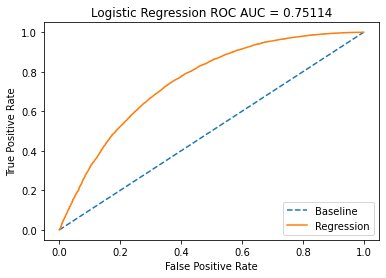

f1 score:= 0.6899
precision: 0.6819
recall: 0.6980
TP = 9000
TN = 8679
P = 12894
N = 12877
acc = 0.6860
Confusion matrix:
[[8679 4198]
 [3894 9000]]


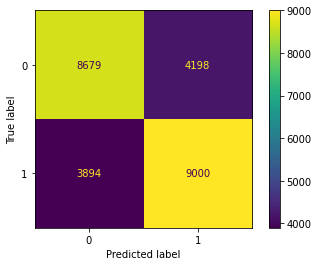

In [108]:
# С учетом гиперпараметров:
model = LogisticRegression(C=21.544346900318832,penalty='l2', max_iter=190)
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
probs = model.predict_proba(X_val)
probs = probs[:,1]

metrics(y_val, probs, y_pred_val)

Применяем преобразования к тестовому файлу

In [109]:
# Применим преобразования к тестовому файлу

test.app_date = pd.to_datetime(test.app_date)
test['month'] = test.app_date.dt.month
test['start_month'] = test.app_date.dt.day < 7
test['decline_app_cnt'] = test['decline_app_cnt'].apply(lambda x: 8 if x  >=  8 else x)
test['decline_app_bin'] = test['decline_app_cnt'].apply(lambda x: 1 if x  >=  1 else 0)
test['income_bin'] = test['income'].apply(lambda x: 1 if x  < 25000  else 0)
for col in ['bki_request_cnt','income',]:
    cut_IQR(col, test)

bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work','start_month',
            'decline_app_bin','income_bin']
cat_cols = ['education', 'home_address','sna','work_address','first_time','month',]
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki','region_rating']    

label_encoder = LabelEncoder()
for column in bin_cols:
    test[column] = label_encoder.fit_transform(test[column])
mode_education  = test['education'].mode()[0]
test['education'] = test['education'].apply(lambda x: mode_education if str(x) == 'nan' else x)
education_dict = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 4, 'ACD': 5}
test.education = test.education.replace(education_dict)

In [110]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
X_num_test = test[num_cols].values
X_bin_test = test[bin_cols].values

X_test = np.hstack([X_num_test, X_bin_test, X_cat_test])

scaler = StandardScaler()
X_test[:,:len(num_cols)] = scaler.fit_transform(X_test[:,:len(num_cols)]) 

y_pred_test = model.predict(X_test)
probs_test = model.predict_proba(X_test)
probs_test = probs_test[:,1]

In [111]:
test['default'] = probs_test
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

submission.to_csv('submission.csv', index=False)

client_id   default
28329      85037  0.390598
22291      22772  0.305817
12305      27987  0.932161
29061      93162  0.326757
27261      13499  0.184504
23193      54871  0.357161
29809     108968  0.228269
27461      36906  0.733930
146        54180  0.599433
15860      32061  0.513228

(36349, 2)